Uber is a taxi service provider as we know, we need to predict the high
booking area using an Unsupervised algorithm and price for the location using a
supervised algorithm and use some map function to display the data

In [1]:
import folium
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

### Preprocessing and visualization

In [2]:
df = pd.read_csv("C:\\Users\\MGC\\Downloads\\assignment\\rideshare_kaggle.csv\\rideshare_kaggle.csv")

In [5]:
df["price"] = df["price"].fillna(value=np.mean(df["price"]))

In [6]:
df["START_DATE"] = pd.to_datetime(df['datetime'], format='%Y/%m/%d %H:%M')

In [7]:
df['HOURS'] = [x.hour for x in df['START_DATE']]
df['DAY'] = [x.day for x in df['START_DATE']]
df['MONTH'] = [x.month for x in df['START_DATE']]
df['DAY_OF_WEEK'] = [x.day_of_week for x in df['START_DATE']]
df["WEEKDAY"] = [calendar.day_name[x.day_of_week] for x in df['START_DATE']]

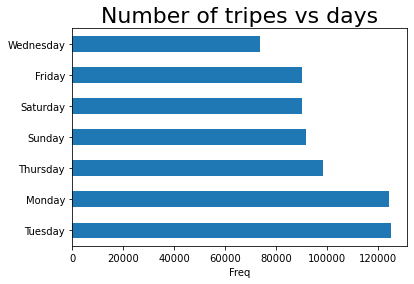

In [8]:
df["WEEKDAY"].value_counts().plot(kind='barh')
plt.xlabel("Freq")
plt.title("Number of tripes vs days", fontsize=22)
plt.show()

In [9]:
df['hourRange'] = df.hour.apply( 
                    lambda x: ('00 - 03 am' if 0<=x<=3 else 
                    ('04 - 07 am' if  4<=x<=7 else 
                    ('08 - 11 am' if  8<=x<=11 else 
                    ('12 - 15 am' if 12<=x<=15 else 
                    ('16 - 19 am' if 16<=x<=19 else 
                    ('20 - 23 am' if 20<=x<=723 else 
                    'missed')))))))
df["hourRange"].sample(10)

231565    08 - 11 am
641777    16 - 19 am
419709    12 - 15 am
663758    20 - 23 am
190944    12 - 15 am
488498    12 - 15 am
598250    12 - 15 am
599578    00 - 03 am
622351    00 - 03 am
529329    08 - 11 am
Name: hourRange, dtype: object

In [10]:
# Threshold for removing correlated variables
threshold = 0.9
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [col for col in upper.columns if any(upper[col] > threshold) ]
print('There are %d columns to remove.' % (len(to_drop)))
to_drop

There are 23 columns to remove.


C:\Users\MGC\AppData\Local\Temp\ipykernel_18280\3469854419.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['apparentTemperature',
 'windGust',
 'windGustTime',
 'temperatureHighTime',
 'temperatureLowTime',
 'apparentTemperatureHigh',
 'apparentTemperatureHighTime',
 'apparentTemperatureLow',
 'apparentTemperatureLowTime',
 'visibility.1',
 'sunriseTime',
 'sunsetTime',
 'uvIndexTime',
 'temperatureMinTime',
 'temperatureMax',
 'temperatureMaxTime',
 'apparentTemperatureMin',
 'apparentTemperatureMinTime',
 'apparentTemperatureMax',
 'apparentTemperatureMaxTime',
 'HOURS',
 'DAY',
 'MONTH']

In [11]:
df = df.drop(columns = to_drop)
print('data shape after removing collinear vaiables: ', df.shape)

data shape after removing collinear vaiables:  (693071, 41)


In [12]:
def outliers(col):
    global col_out
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3-Q1
    upper_limit = Q3 + (IQR*1.5)
    lower_limit = Q1 - (IQR*1.5)
    df1 = df[ (df[col] > upper_limit) | (df[col] < lower_limit)] 
    df.loc[ (df[col] > upper_limit) | (df[col] < lower_limit),col]=np.nan
    if df1.shape[0] != 0:
        print(col, ":", df1.shape)
        print('-----------------')
        col_out.append(col)
    return col_out, df1.shape[0]

In [13]:
numerical = df.select_dtypes(['int64', 'float64']).columns
print("number of outliers for each column")
print('-----------------')
l = []
col_out = []
for col in numerical:
    col_out, val = outliers(col)
    l.append(val)

number of outliers for each column
-----------------
price : (7982, 41)
-----------------
distance : (8662, 41)
-----------------
surge_multiplier : (20975, 41)
-----------------
latitude : (88546, 41)
-----------------
temperature : (36659, 41)
-----------------
precipIntensity : (150828, 41)
-----------------
precipProbability : (150828, 41)
-----------------
visibility : (136839, 41)
-----------------
temperatureHigh : (163878, 41)
-----------------
dewPoint : (37283, 41)
-----------------
uvIndex : (159407, 41)
-----------------
temperatureMin : (4447, 41)
-----------------


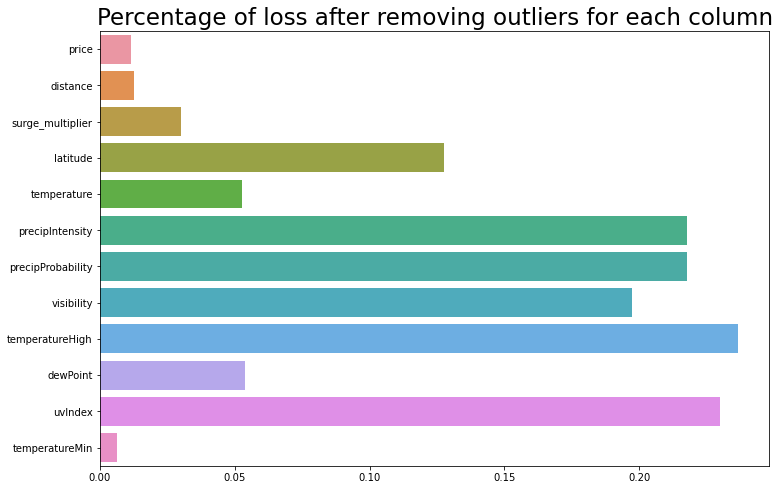

In [14]:
l = list(filter(lambda num: num != 0, l))
l = [i/df.shape[0] for i in l]
plt.figure(figsize = (12,8))
sns.barplot(x=l, y=col_out)
plt.title("Percentage of loss after removing outliers for each column", fontsize=23)
plt.show()

In [15]:
df["price_per_mile"] = df["price"] / df["distance"]

In [16]:
print('Before deleting outliers: ',df.shape)
df.dropna(inplace=True)
print('After deleting outliers: ',df.shape)

Before deleting outliers:  (693071, 42)
After deleting outliers:  (234930, 42)


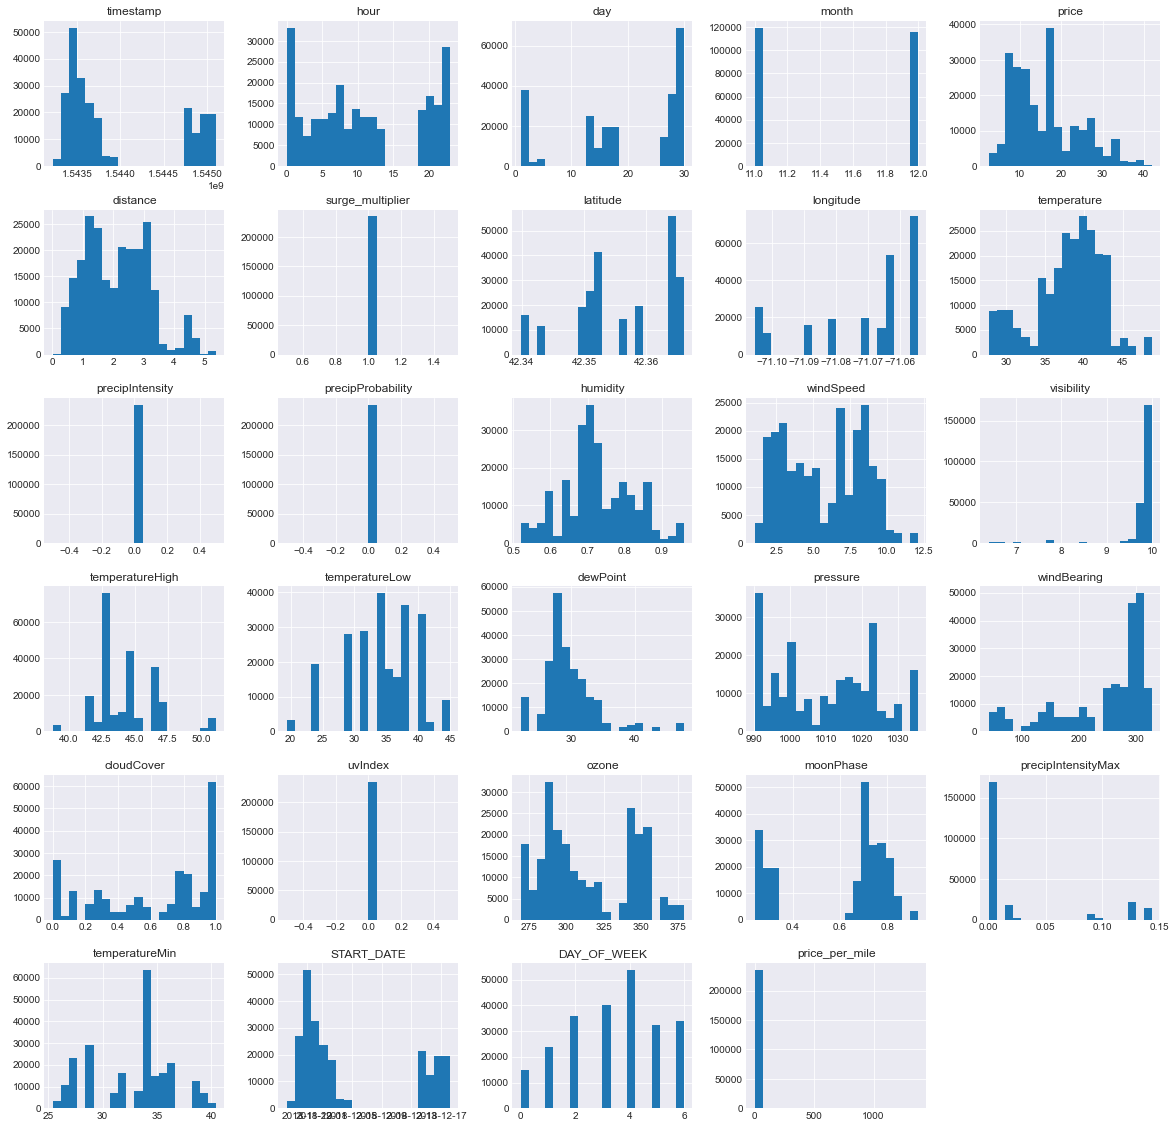

In [17]:
style.use("seaborn-darkgrid")
df.hist(figsize=(20,20), bins=20)
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
for i in df.columns:
    if df[i].dtype == "O":
        df[i] = le.fit_transform(df[i])

### KMEANS Clustering  

In [20]:
# Select relevant columns for clustering
columns_for_clustering = ['latitude', 'longitude', 'price', 'distance', 'temperature', 'humidity']

# Extract the data for clustering

cluster_data = df[columns_for_clustering]

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(cluster_data)

# Add cluster labels to the DataFrame
df['cluster_label'] = kmeans.labels_


In [22]:
# Calculate inertia
inertia = kmeans.inertia_
print("Inertia:", inertia)


Inertia: 4122790.652568973


In [44]:
import random
# Define the number of samples to display on the map
num_samples = 1000  # Adjust this number as per your preference and system capabilities

# Randomly select a subset of samples
random_indices = random.sample(range(len(df)), min(num_samples, len(df)))
sampled_df = df.iloc[random_indices]

# Create a map centered on a specific location
map_center = [42.3647, -71.0542]  # Latitude and longitude of the map center
map_zoom = 12  # Zoom level of the map

# Create the map object
m = folium.Map(location=map_center, zoom_start=map_zoom)

# Add markers for each sampled Uber trip
for _, row in sampled_df.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    
    # Add a marker for each Uber trip
    folium.Marker([lat, lon]).add_to(m)

# Display the map


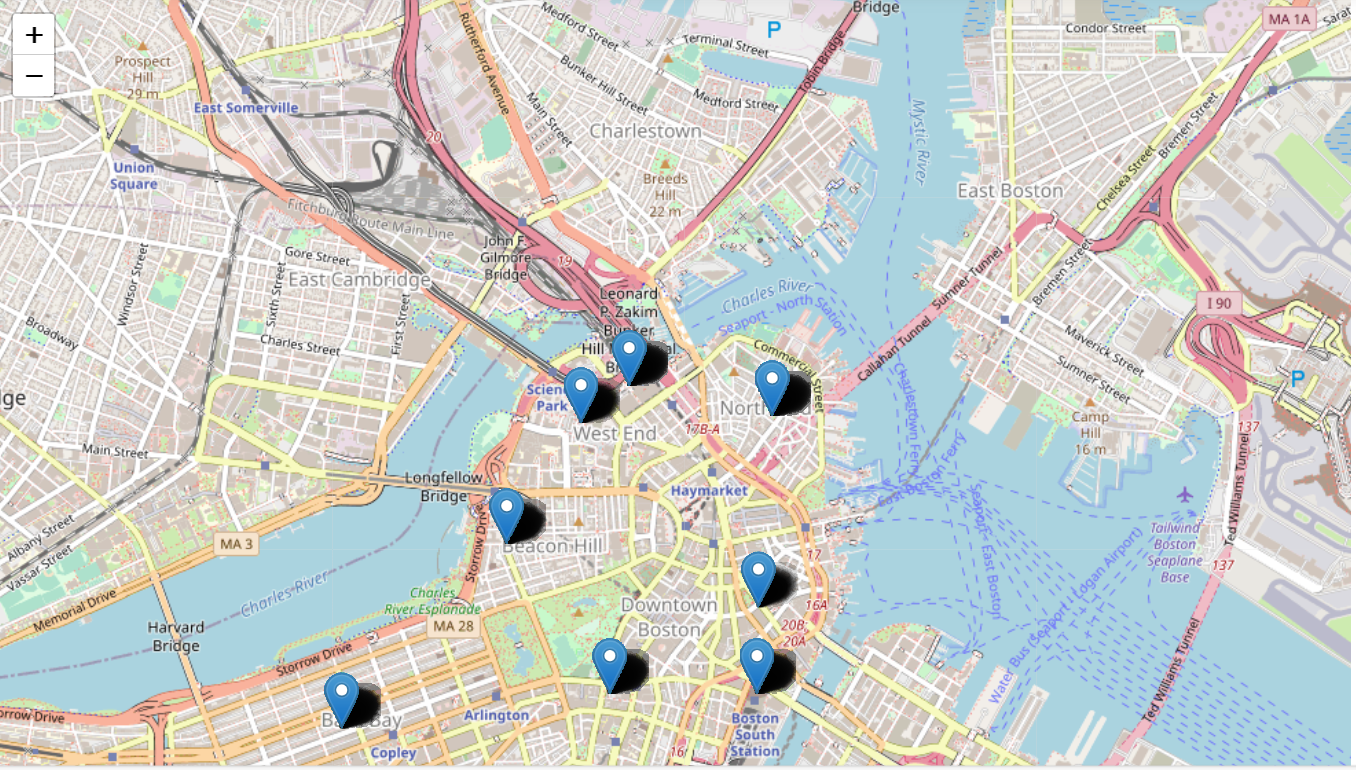

### PRECIDTING PRICES USING CATBOOSTREGRESSOR

In [23]:
df.dropna(inplace = True)
X=df.drop(['price',"START_DATE","price_per_mile"],axis=1)
y=df['price_per_mile']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=40)


In [24]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

# Use the Pool constructor
train_data = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_data = Pool(X_test, y_test, cat_features=categorical_features_indices)

C:\Users\MGC\AppData\Local\Temp\ipykernel_18280\2187435708.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X.dtypes != np.float)[0]


In [26]:
model = CatBoostRegressor(depth= 6, l2_leaf_reg= 3, iterations= 1000, learning_rate=0.1)

In [40]:
model.fit(train_data)

0:	learn: 12.8968089	total: 541ms	remaining: 9m
1:	learn: 12.1803342	total: 1.06s	remaining: 8m 50s
2:	learn: 11.5914075	total: 1.54s	remaining: 8m 32s
3:	learn: 11.0032521	total: 2.1s	remaining: 8m 42s
4:	learn: 10.5366008	total: 2.72s	remaining: 9m
5:	learn: 9.9182967	total: 3.2s	remaining: 8m 50s
6:	learn: 9.4205984	total: 3.69s	remaining: 8m 43s
7:	learn: 9.0195153	total: 4.2s	remaining: 8m 40s
8:	learn: 8.6530522	total: 4.61s	remaining: 8m 27s
9:	learn: 8.2559253	total: 4.98s	remaining: 8m 12s
10:	learn: 8.0007819	total: 5.37s	remaining: 8m 2s
11:	learn: 7.7989586	total: 5.76s	remaining: 7m 54s
12:	learn: 7.5439901	total: 6.17s	remaining: 7m 48s
13:	learn: 7.3902113	total: 6.59s	remaining: 7m 44s
14:	learn: 7.0513301	total: 7.03s	remaining: 7m 41s
15:	learn: 6.8672655	total: 7.54s	remaining: 7m 43s
16:	learn: 6.5165945	total: 8.02s	remaining: 7m 43s
17:	learn: 6.3645648	total: 8.51s	remaining: 7m 44s
18:	learn: 6.2186440	total: 8.96s	remaining: 7m 42s
19:	learn: 5.8919186	total: 9

159:	learn: 1.7339020	total: 1m 4s	remaining: 5m 39s
160:	learn: 1.7338597	total: 1m 5s	remaining: 5m 39s
161:	learn: 1.7011884	total: 1m 5s	remaining: 5m 38s
162:	learn: 1.6947799	total: 1m 5s	remaining: 5m 37s
163:	learn: 1.6849298	total: 1m 6s	remaining: 5m 37s
164:	learn: 1.6849276	total: 1m 6s	remaining: 5m 36s
165:	learn: 1.6692430	total: 1m 6s	remaining: 5m 35s
166:	learn: 1.6621349	total: 1m 7s	remaining: 5m 34s
167:	learn: 1.6583353	total: 1m 7s	remaining: 5m 34s
168:	learn: 1.6533788	total: 1m 7s	remaining: 5m 34s
169:	learn: 1.6414248	total: 1m 8s	remaining: 5m 33s
170:	learn: 1.6373519	total: 1m 8s	remaining: 5m 33s
171:	learn: 1.6298398	total: 1m 9s	remaining: 5m 32s
172:	learn: 1.6243130	total: 1m 9s	remaining: 5m 31s
173:	learn: 1.6222869	total: 1m 9s	remaining: 5m 31s
174:	learn: 1.6222811	total: 1m 10s	remaining: 5m 30s
175:	learn: 1.6210222	total: 1m 10s	remaining: 5m 30s
176:	learn: 1.6210180	total: 1m 10s	remaining: 5m 29s
177:	learn: 1.6209568	total: 1m 11s	remaini

312:	learn: 1.2329132	total: 2m 2s	remaining: 4m 28s
313:	learn: 1.2314808	total: 2m 2s	remaining: 4m 27s
314:	learn: 1.2314688	total: 2m 2s	remaining: 4m 27s
315:	learn: 1.2286232	total: 2m 3s	remaining: 4m 26s
316:	learn: 1.2244059	total: 2m 3s	remaining: 4m 26s
317:	learn: 1.2222781	total: 2m 3s	remaining: 4m 25s
318:	learn: 1.2222532	total: 2m 4s	remaining: 4m 25s
319:	learn: 1.2189736	total: 2m 4s	remaining: 4m 25s
320:	learn: 1.2181979	total: 2m 5s	remaining: 4m 24s
321:	learn: 1.2176487	total: 2m 5s	remaining: 4m 24s
322:	learn: 1.2172195	total: 2m 5s	remaining: 4m 23s
323:	learn: 1.2131523	total: 2m 6s	remaining: 4m 23s
324:	learn: 1.2094290	total: 2m 6s	remaining: 4m 22s
325:	learn: 1.2088585	total: 2m 6s	remaining: 4m 21s
326:	learn: 1.2082280	total: 2m 7s	remaining: 4m 21s
327:	learn: 1.2048112	total: 2m 7s	remaining: 4m 20s
328:	learn: 1.2041083	total: 2m 7s	remaining: 4m 20s
329:	learn: 1.2036189	total: 2m 8s	remaining: 4m 20s
330:	learn: 1.2030336	total: 2m 8s	remaining: 

465:	learn: 1.0554846	total: 3m 4s	remaining: 3m 31s
466:	learn: 1.0540644	total: 3m 4s	remaining: 3m 30s
467:	learn: 1.0534847	total: 3m 5s	remaining: 3m 30s
468:	learn: 1.0528600	total: 3m 5s	remaining: 3m 30s
469:	learn: 1.0520209	total: 3m 5s	remaining: 3m 29s
470:	learn: 1.0518707	total: 3m 6s	remaining: 3m 29s
471:	learn: 1.0515552	total: 3m 6s	remaining: 3m 28s
472:	learn: 1.0512265	total: 3m 7s	remaining: 3m 28s
473:	learn: 1.0504111	total: 3m 7s	remaining: 3m 28s
474:	learn: 1.0502096	total: 3m 7s	remaining: 3m 27s
475:	learn: 1.0493375	total: 3m 8s	remaining: 3m 27s
476:	learn: 1.0486218	total: 3m 8s	remaining: 3m 26s
477:	learn: 1.0484041	total: 3m 9s	remaining: 3m 26s
478:	learn: 1.0473799	total: 3m 9s	remaining: 3m 26s
479:	learn: 1.0471665	total: 3m 9s	remaining: 3m 25s
480:	learn: 1.0468944	total: 3m 10s	remaining: 3m 25s
481:	learn: 1.0466423	total: 3m 10s	remaining: 3m 24s
482:	learn: 1.0450219	total: 3m 11s	remaining: 3m 24s
483:	learn: 1.0414047	total: 3m 11s	remaini

619:	learn: 0.9530274	total: 4m 7s	remaining: 2m 31s
620:	learn: 0.9519367	total: 4m 8s	remaining: 2m 31s
621:	learn: 0.9515204	total: 4m 8s	remaining: 2m 31s
622:	learn: 0.9500271	total: 4m 9s	remaining: 2m 30s
623:	learn: 0.9497163	total: 4m 9s	remaining: 2m 30s
624:	learn: 0.9494461	total: 4m 9s	remaining: 2m 29s
625:	learn: 0.9491230	total: 4m 10s	remaining: 2m 29s
626:	learn: 0.9480896	total: 4m 10s	remaining: 2m 29s
627:	learn: 0.9471766	total: 4m 11s	remaining: 2m 28s
628:	learn: 0.9468696	total: 4m 11s	remaining: 2m 28s
629:	learn: 0.9468060	total: 4m 12s	remaining: 2m 28s
630:	learn: 0.9462584	total: 4m 12s	remaining: 2m 27s
631:	learn: 0.9461076	total: 4m 13s	remaining: 2m 27s
632:	learn: 0.9459404	total: 4m 13s	remaining: 2m 27s
633:	learn: 0.9440934	total: 4m 14s	remaining: 2m 26s
634:	learn: 0.9440008	total: 4m 14s	remaining: 2m 26s
635:	learn: 0.9439934	total: 4m 15s	remaining: 2m 25s
636:	learn: 0.9432135	total: 4m 15s	remaining: 2m 25s
637:	learn: 0.9428866	total: 4m 16

773:	learn: 0.8721350	total: 5m 16s	remaining: 1m 32s
774:	learn: 0.8715798	total: 5m 17s	remaining: 1m 32s
775:	learn: 0.8709373	total: 5m 17s	remaining: 1m 31s
776:	learn: 0.8709259	total: 5m 18s	remaining: 1m 31s
777:	learn: 0.8699526	total: 5m 18s	remaining: 1m 30s
778:	learn: 0.8698573	total: 5m 19s	remaining: 1m 30s
779:	learn: 0.8698108	total: 5m 19s	remaining: 1m 30s
780:	learn: 0.8697575	total: 5m 20s	remaining: 1m 29s
781:	learn: 0.8695745	total: 5m 20s	remaining: 1m 29s
782:	learn: 0.8694195	total: 5m 20s	remaining: 1m 28s
783:	learn: 0.8692917	total: 5m 21s	remaining: 1m 28s
784:	learn: 0.8690869	total: 5m 22s	remaining: 1m 28s
785:	learn: 0.8689648	total: 5m 22s	remaining: 1m 27s
786:	learn: 0.8688079	total: 5m 23s	remaining: 1m 27s
787:	learn: 0.8687358	total: 5m 23s	remaining: 1m 27s
788:	learn: 0.8677938	total: 5m 24s	remaining: 1m 26s
789:	learn: 0.8674714	total: 5m 24s	remaining: 1m 26s
790:	learn: 0.8672841	total: 5m 25s	remaining: 1m 25s
791:	learn: 0.8670014	total:

928:	learn: 0.8242390	total: 6m 30s	remaining: 29.9s
929:	learn: 0.8241824	total: 6m 31s	remaining: 29.5s
930:	learn: 0.8240456	total: 6m 31s	remaining: 29s
931:	learn: 0.8232461	total: 6m 32s	remaining: 28.6s
932:	learn: 0.8231787	total: 6m 32s	remaining: 28.2s
933:	learn: 0.8229626	total: 6m 32s	remaining: 27.8s
934:	learn: 0.8229378	total: 6m 33s	remaining: 27.3s
935:	learn: 0.8227356	total: 6m 33s	remaining: 26.9s
936:	learn: 0.8226587	total: 6m 34s	remaining: 26.5s
937:	learn: 0.8225078	total: 6m 34s	remaining: 26.1s
938:	learn: 0.8225063	total: 6m 35s	remaining: 25.7s
939:	learn: 0.8224795	total: 6m 35s	remaining: 25.3s
940:	learn: 0.8223144	total: 6m 36s	remaining: 24.8s
941:	learn: 0.8222811	total: 6m 36s	remaining: 24.4s
942:	learn: 0.8221650	total: 6m 37s	remaining: 24s
943:	learn: 0.8214786	total: 6m 37s	remaining: 23.6s
944:	learn: 0.8211917	total: 6m 38s	remaining: 23.2s
945:	learn: 0.8211274	total: 6m 38s	remaining: 22.8s
946:	learn: 0.8203657	total: 6m 39s	remaining: 22.

In [41]:
pred = model.predict(X_test)
pred

array([21.51566567,  5.72360516, 13.0068448 , ..., 14.84921766,
        4.20466166,  3.55363207])

In [42]:
y_true =np.array(y_test)

#### EVALUATING MODEL 

In [43]:
r2 = model.score(test_data) 
rmse = (np.sqrt(mean_squared_error(y_true, pred)))
print("R2:", r2)
print("RMSE:", rmse)

R2: 0.956821754035951
RMSE: 2.9605631176488325
